In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pickle

### Read in data

In [219]:
df2 = pd.read_csv('../datasets/alaska_single_engine_clean.csv')

In [220]:
len(df2['model'].unique())

1074

## Double check 

In [221]:
df2['highest_injury_level'].value_counts()

None Reported    4080
Minor             640
Fatal             621
Serious           387
Name: highest_injury_level, dtype: int64

In [222]:
df2['aircraft_damage'].value_counts()

Substantial      4982
Destroyed         537
Minor             134
None Reported      52
None               18
Unknown             5
Name: aircraft_damage, dtype: int64

In [223]:
df2['model'] = df2['model'].str.upper()

In [224]:
df2['make'] = df2['make'].str.upper()

### Binarize and engineer

In [225]:
df2['occurred_near_airpor'] = 1 - df2['airport_name'].str.contains('Unknown').astype(int)

In [226]:
df2['purpose_of_flight'] = df2['purpose_of_flight'].map(lambda x: 'UNK' if x=='Unknown' else x)

In [227]:
def is_top_model(model, top_x):
    top_list = list(df2['model'].value_counts()[:top_x + 1].index.str.upper())
    return True if model.upper() in top_list else False

In [228]:
df2['model'] = [x.upper() if is_top_model(x,200) else 'UNCOMMON MODEL' for x in df2['model']]

In [229]:
def is_top_make(make, top_x):
    top_list = list(df2['make'].value_counts()[:top_x + 1].index.str.upper())
    return True if make.upper() in top_list else False

In [230]:
df2['make'] = [x.upper() if is_top_make(x,50) else 'UNCOMMON MAKE' for x in df2['make']]


In [231]:
df2['scheduled'] = df2['scheduled'].map(lambda x: 'UNK' if x == 'Unknown' else x)

### Create X

In [264]:
X = df2.drop(['ntsb_no', 'probable_cause', 'airport_name', 'event_type', 'mkey', 'city', 'n', 'has_safety_rec', 'report_type', 'highest_injury_level', 'fatal_injury_count', 'serious_injury_count', 'minor_injury_count', 'airport_id', 'far', 'aircraft_damage', 'operator', 'event_year', 'event_season', 'event_day', 'aircraft_category', 'has_injury', 'event_time','has_aircraft_damage'], axis=1)

### Create Y

In [234]:
y = df2['has_injury']

In [263]:
baseline = 1 - y.mean()
baseline

0.7122905027932961

### Create dummies

In [265]:
X_dummy = pd.get_dummies(data=X,
                         columns=['make', 'model', 'scheduled', 'purpose_of_flight', 'weather_condition', 'event_month', 'event_hour'],
                         drop_first=True
        )

In [266]:
X_dummy.shape

(5728, 312)

0.7122905027932961

### Add constant for use in GLM

In [267]:
X_con = sm.add_constant(X_dummy[list(X_dummy.columns)])

In [268]:
X_con.shape

(5728, 313)

### Train test split

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X_con, y, random_state=2023)

In [269]:
X_train.shape

(4296, 313)

In [270]:
glm_bin = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Binomial(link=sm.families.links.Logit())).fit()

In [271]:
glm_bin_results = glm_bin.summary()

In [243]:
test_pred = glm_bin.predict(X_test)

In [244]:
test_pred = test_pred.map(lambda x: 1 if x >=0.40 else 0)

In [245]:
def glm_accuracy(model, x, y):
    test_pred = model.predict(x)
    test_pred = test_pred.map(lambda x: 1 if x >=0.50 else 0)
    acc = pd.concat([test_pred, y], axis = 1)
    return acc[acc.iloc[:, 0] == acc.iloc[:, 1]].shape[0] / y.shape[0]

In [246]:
# acc = pd.concat([test_pred, y_test], axis = 1)

In [247]:
#acc.rename({0 :'predicted', 'has_injury' : 'actual'}, axis =1 , inplace = True)

In [248]:
#accuracy = acc[(acc['predicted'] == acc['actual'])].shape[0] / y_test.shape[0]

In [249]:
#glm_accuracy(glm_bin, X_test, y_test)

In [272]:
glm_bin_pvalues = np.round(glm_bin.pvalues, 4).to_frame().sort_values(by =  0, ascending = True)

In [251]:
glm_bin_coef_df = glm_bin.params.to_frame().sort_values(by = 0, ascending = False)
glm_bin_coef_df

,0
purpose_of_flight_PUBL,47.624106
model_A-1B,27.429406
make_MCDONNELL DOUGLAS HELICOPTER,27.023862
make_CONSOLIDATED AERONAUTICS INC.,26.826940
model_177,26.583769
...,...
model_DHC-6,-25.852478
make_SHORT BROS. & HARLAND,-26.080935
model_MD-82,-27.468717
make_AVIAT AIRCRAFT INC,-27.499618


In [252]:
glm_bin_coef_df = glm_bin.params.to_frame().sort_values(by = 0, ascending = False)

In [253]:
glm_bin_pvalues.rename({0: 'p_value'}, axis = 1, inplace=True)

In [254]:
glm_bin_coef_df.rename({0: 'coef'}, axis = 1, inplace=True)

In [273]:
glm_bin_pvalues

,0
weather_condition_VMC,0.0000
is_accident,0.0000
occurred_near_airpor,0.0000
amateur_built,0.0557
weather_condition_Unknown,0.0580
...,...
purpose_of_flight_FERY,0.9999
const,0.9999
model_8KCAB,1.0000
make_GATES LEARJET,1.0000


In [255]:
# glm_bin_pvalues.to_csv('../results/GLM_BIN-1_PVALUES.csv')

In [256]:
# glm_poi_coef_df.to_csv('../results/GLM_POI_COEF_ACC-724.csv')

In [257]:
    def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
      
        matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(matrix, annot=True, fmt='g', cmap="Blues", 
                    xticklabels=['Predicted No Injuries', 'Predicted Injuries'], 
                    yticklabels=['Actually No Injuries', 'Actually Had Injuries'])
        plt.title(title)
        plt.show()

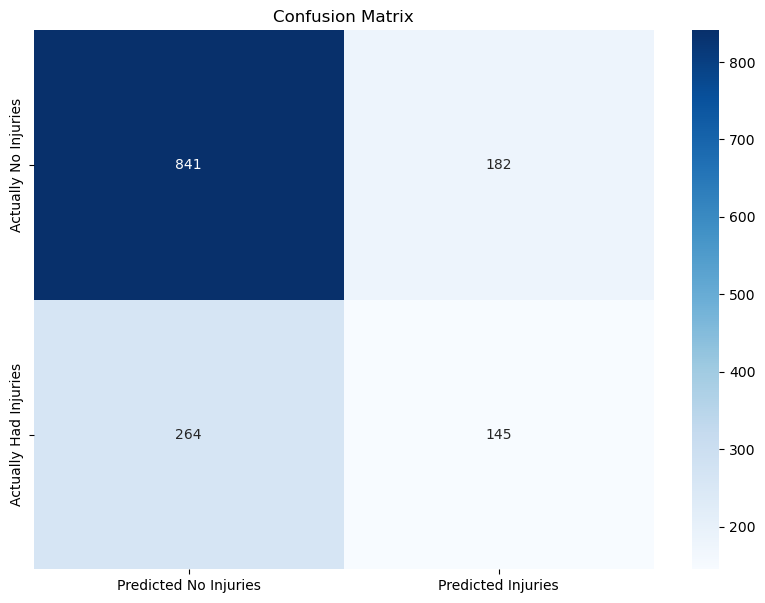

In [258]:
plot_confusion_matrix(y_test, test_pred)

In [259]:
X = df2[['make', 'model']]

In [260]:
glm1 = aviation_data_model(X,y, [
    ('make', 'CESSNA'),
    ('model', 'PA-18'),
    ('scheduled', 'first'),
    ('purpose_of_flight', 'first'),
    ('weather_condition', 'first'),
    ('event_month', 'first'),
    ('event_hour', 'first')
])

In [261]:
glm1.fit_binomial()

KeyError: "['scheduled', 'purpose_of_flight', 'weather_condition', 'event_month', 'event_hour'] not in index"

In [ ]:
glm1.pvalues.head(50)

In [ ]:
class aviation_data_model:
    def __init__(self, x, y, drop_categories = None, random_state = 2023):
        self.model = None
        self.x_oh = None
        self.results = None
        self.x = x.copy()
        self.drop_categories = drop_categories
        self.y = y
        self.random_state = random_state
        self.pvalues = None

        
    def one_hot(self):
        if type(self.drop_categories[0]) == tuple:
            categories = []
            for i, j in self.drop_categories:
                categories.append(i)
                if j != 'first':
                    self.x[i] = np.where(self.x[i] == j, '0-' + j, self.x[i])
        else:
            raise TypeError('Invalid OneHotEncoder values. Use None or a list of tuples of (column name, category name')
        self.x_oh = pd.get_dummies(self.x, columns = categories, drop_first=True)
        print(f"OneHot Resulting Shape: {self.x_oh.shape}")
        return self.x_oh
    
    def train_test(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=self.random_state)
        return (X_train, X_test, y_train, y_test)
        
    
    def fit_binomial(self):
        if self.drop_categories:
            oh = self.one_hot()
        x_con = sm.add_constant(oh[list(oh.columns)])
        print(f"After constant Resulting Shape: {x_con.shape}")
        X_train, X_test, y_train, y_test = self.train_test(x_con, self.y)
        print(f"After tts X_train Resulting Shape: {X_train.shape}")
        print(f"After tts X_test Resulting Shape: {X_test.shape}")
        print(f"After tts y_train Resulting Shape: {y_train.shape}")
        print(f"After tts y_test Resulting Shape: {y_test.shape}")
        # print(X_train.dtypes)
        glm_bin = sm.GLM(
            y_train,
            X_train,
            family=sm.families.Binomial(link=sm.families.links.Logit())).fit()
        self.results = glm_bin.summary()
        self.model = glm_bin
        self.pvalues = np.round(glm_bin.pvalues).to_frame().sort_values(by = 0)

In [ ]:
glm1.x_oh